<a href="https://colab.research.google.com/github/Lauriano-Viana/fase-06-entreg-02/blob/main/fase06_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento modelo detecção imagens
## modelo CNN

In [ ]:
# Importando as bibliotecas necessárias
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive

### Conectar googledrive para ter acesso ao dataset de imagens

In [ ]:
# conectar googledrive
drive.mount('/content/drive')

Mounted at /content/drive


### Definindo o caminho para o dataset no google drive

In [ ]:
base_dir = '/content/drive/MyDrive/datasets'  # Ajuste este caminho
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')

 ### Verificar se os diretórios e arquivos necessários estão presentes antes de executar operações mais complexas.

In [ ]:
# Verificar a estrutura do diretório
print(f"Verificando diretórios...")
if os.path.exists(base_dir):
    print(f"Diretórios encontrados em {base_dir}: {os.listdir(base_dir)}")
    if os.path.exists(images_dir):
        print(f"Total de imagens: {len(os.listdir(images_dir))}")
    if os.path.exists(labels_dir):
        print(f"Total de arquivos de labels: {len(os.listdir(labels_dir))}")
else:
    print(f"Diretório base {base_dir} não encontrado. Verifique o caminho.")

Verificando diretórios...
Diretórios encontrados em /content/drive/MyDrive/datasets: ['labels', 'images', 'train', 'validation']
Total de imagens: 74
Total de arquivos de labels: 74


 ### Criar caminhos de diretórios de treino e validação para um conjunto de dados (dataset) organizado.

In [ ]:
# Criar diretórios para o dataset organizado
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

### Definir os parametros para o modelo

In [ ]:
# Parâmetros para o modelo
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 45
NUM_CLASSES = 2  # onça e cobra

### Função que recebe os labels no formato TXT e identifica a qual classe ele pertence

In [ ]:
# Função para ler o label de um arquivo TXT
def read_label_from_txt(txt_path):
    """
    Lê o arquivo de label TXT e retorna a classe
    Formato esperado no TXT: Primeiro número indica a classe (0=onça, 1=cobra)
    """
    try:
        with open(txt_path, 'r') as f:
            # Lê a primeira linha e pega o primeiro valor como ID da classe
            class_id = int(f.readline().strip().split()[0])
            # Retorna o nome da classe baseado no ID
            return 'onca' if class_id == 0 else 'cobra'
    except Exception as e:
        print(f"Erro ao ler {txt_path}: {e}")
        return None

### Agora é organizar o dataset:

Função que prepara um dataset estruturado para treinamento, organizando imagens de onças e cobras em pastas de treino/validação com base em arquivos de labels, seguindo a proporção 80/20 e mantendo o equilíbrio entre as classes.

In [ ]:
# Função para organizar o dataset
def setup_dataset():
    """
    Organiza o dataset em estrutura adequada para treinamento e validação
    baseado nos arquivos de labels TXT
    """
    # Limpar diretórios organizados se já existirem
    for dir_path in [train_dir, val_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)

    # Criar novos diretórios
    for dir_path in [train_dir, val_dir]:
        os.makedirs(os.path.join(dir_path, 'onca'), exist_ok=True)
        os.makedirs(os.path.join(dir_path, 'cobra'), exist_ok=True)

    print("Organizando dataset...")

    # Obter a lista de imagens
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Embaralhar a lista para aleatorizar
    np.random.seed(42)  # Para reprodutibilidade
    np.random.shuffle(image_files)

    # Separar em conjuntos de treino (80%) e validação (20%)
    split_idx = int(len(image_files) * 0.8)
    train_files = image_files[:split_idx]
    val_files = image_files[split_idx:]

    print(f"Total de {len(train_files)} imagens para treino e {len(val_files)} para validação")

    # Distribuir as imagens para as pastas apropriadas
    processed = 0
    skipped = 0

    # Processar arquivos de treino
    for img_file in train_files:
        # Arquivo base sem extensão
        base_name = os.path.splitext(img_file)[0]
        # Caminho para o arquivo de label correspondente
        label_file = os.path.join(labels_dir, f"{base_name}.txt")

        if os.path.exists(label_file):
            # Ler a classe do arquivo de label
            class_name = read_label_from_txt(label_file)
            if class_name:
                # Copiar a imagem para o diretório correto
                src = os.path.join(images_dir, img_file)
                dst = os.path.join(train_dir, class_name, img_file)
                shutil.copy(src, dst)
                processed += 1
        else:
            skipped += 1

    # Processar arquivos de validação
    for img_file in val_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = os.path.join(labels_dir, f"{base_name}.txt")

        if os.path.exists(label_file):
            class_name = read_label_from_txt(label_file)
            if class_name:
                src = os.path.join(images_dir, img_file)
                dst = os.path.join(val_dir, class_name, img_file)
                shutil.copy(src, dst)
                processed += 1
        else:
            skipped += 1

    print(f"Dataset organizado: {processed} imagens processadas, {skipped} imagens sem label.")

    # Verificar o número de imagens em cada classe
    for subset, dir_path in [("Treino", train_dir), ("Validação", val_dir)]:
        onca_count = len(os.listdir(os.path.join(dir_path, 'onca')))
        cobra_count = len(os.listdir(os.path.join(dir_path, 'cobra')))
        print(f"{subset}: {onca_count} onças, {cobra_count} cobras")


### Este código cria um gerador de dados de treinamento com aumento de dados.

Onde sua função é preparar as imagens para o treinamento de um modelo de deep learning, aplicando transformações aleatórias para aumentar a diversidade do dataset e evitar overfitting.

In [ ]:
# Configurar o dataset
setup_dataset()

# Geradores de dados com aumento de dados para treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Organizando dataset...
Total de 59 imagens para treino e 15 para validação
Dataset organizado: 74 imagens processadas, 0 imagens sem label.
Treino: 30 onças, 29 cobras
Validação: 7 onças, 8 cobras


 ### configura os geradores de dados para treinamento e validação de um modelo de deep learning, carregando imagens de diretórios e preparando-as para o processamento pela rede neural.

In [ ]:
# Validação apenas com rescale
validation_datagen = ImageDataGenerator(rescale=1./255)

# Carregar os dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 59 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


### Mostrar as classes encontradas

In [ ]:
# Verificar as classes
class_indices = train_generator.class_indices
print(f"Classes encontradas: {class_indices}")

Classes encontradas: {'cobra': 0, 'onca': 1}


### Definir uma rede neural convolucional (CNN) usando o Keras/TensorFlow, projetada para classificação de imagens (no caso, entre "onça" e "cobra")

In [ ]:
# Construir o modelo CNN
model = Sequential([
    # Primeira camada convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),

    # Segunda camada convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Terceira camada convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Quarta camada convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten e camadas densas
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Para reduzir overfitting
    Dense(NUM_CLASSES, activation='softmax')  # Saída: onça ou cobra
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilar o modelo de rede neural construído anteriormente, configurando três elementos essenciais para o treinamento:

1. Otimizador (optimizer)
2. Função de Perda (loss)
3. Métricas de Avaliação (metrics)

In [ ]:
# Compilar o modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Resumo do modelo

In [ ]:
# Resumo do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,554 (36.92 MB)

 Trainable params: 9,679,554 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

### Definir callbacks (funções executadas durante o treinamento) para melhorar o processo e salvar o melhor modelo. Essas ferramentas ajudam a evitar overfitting, interromper o treino quando necessário e salvar automaticamente os melhores resultados.

In [ ]:
# Callbacks para melhorar o treinamento
checkpoint_path = os.path.join(base_dir, 'onca_cobra_model.h5')
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

### Executar o treinamento da CNN, avalia seu desempenho, salva os resultados e prepara o modelo para previsões em novas imagens.

Fluxo Principal

    Treina o modelo com callbacks para evitar overfitting.

    Salva o melhor modelo e histórico de treino.

    Analisa desempenho com métricas e visualizações.

    Prepara o modelo para uso em novas imagens.


Epoch 1/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6296 - loss: 0.6947
Epoch 1: val_accuracy did not improve from 0.80000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - accuracy: 0.6296 - loss: 0.6947 - val_accuracy: 0.4667 - val_loss: 0.6766
Epoch 2/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7188 - loss: 0.6703
Epoch 2: val_accuracy did not improve from 0.80000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7188 - loss: 0.6703 - val_accuracy: 0.4667 - val_loss: 0.6774
Epoch 3/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.6562 - loss: 0.6630
Epoch 3: val_accuracy did not improve from 0.80000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.6562 - loss: 0.6630 - val_accuracy: 0.4667 - val_loss: 0.6827
Epoch 4/45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.4815 - loss: 0.6938
Epoch 4: val_accuracy did not improve from 0.80000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.4815 - loss: 0.6938 - val_accuracy: 0.4667 - val_loss: 0.6813


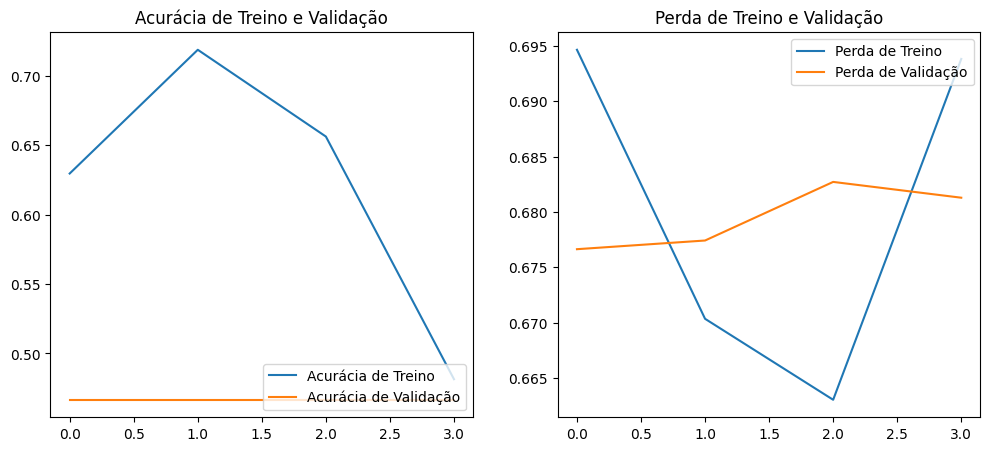

Avaliando o modelo...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.4667 - loss: 0.6766
Perda: 0.6766
Acurácia: 0.4667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


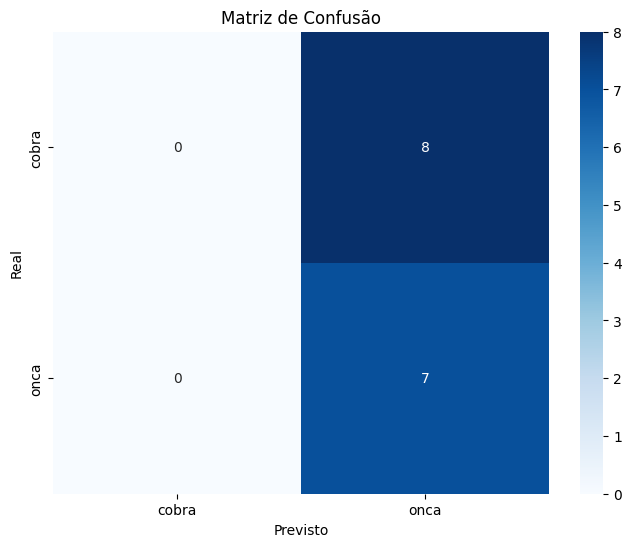

Relatório de Classificação:
              precision    recall  f1-score   support

       cobra       0.00      0.00      0.00         8
        onca       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.23      0.50      0.32        15
weighted avg       0.22      0.47      0.30        15


Como usar o modelo para fazer previsões em novas imagens:
predict_image('/caminho/para/sua/imagem.jpg')
Treinamento e avaliação concluídos!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Verificar se há imagens suficientes antes de treinar
if train_generator.samples > 0 and validation_generator.samples > 0:
    # Ajustar steps_per_epoch e validation_steps
    steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
    validation_steps = max(1, validation_generator.samples // BATCH_SIZE)

    # Treinar o modelo
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    # Salvar o modelo final
    model.save(os.path.join(base_dir, 'onca_cobra_final_model.h5'))

    # Plotar o histórico de treinamento
    def plot_training_history(history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(len(acc))

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Acurácia de Treino')
        plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
        plt.legend(loc='lower right')
        plt.title('Acurácia de Treino e Validação')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Perda de Treino')
        plt.plot(epochs_range, val_loss, label='Perda de Validação')
        plt.legend(loc='upper right')
        plt.title('Perda de Treino e Validação')

        plt.savefig(os.path.join(base_dir, 'training_history.png'))
        plt.show()

    plot_training_history(history)

    # Avaliar o modelo no conjunto de validação
    print("Avaliando o modelo...")
    eval_result = model.evaluate(validation_generator)
    print(f"Perda: {eval_result[0]:.4f}")
    print(f"Acurácia: {eval_result[1]:.4f}")

    # Fazer previsões no conjunto de validação para análise detalhada
    validation_generator.reset()
    y_pred = []
    y_true = []

    for i in range(validation_steps):
        x, y = next(validation_generator)
        predictions = model.predict(x)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(y, axis=1))

    # Truncar para o número exato de amostras de validação
    y_pred = y_pred[:validation_generator.samples]
    y_true = y_true[:validation_generator.samples]

    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    class_names = list(class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.savefig(os.path.join(base_dir, 'confusion_matrix.png'))
    plt.show()

    # Imprimir relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Função para fazer previsões em novas imagens
    def predict_image(img_path):
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) / 255.0

        prediction = model.predict(img_array)
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction)

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f'Previsão: {predicted_class} (Confiança: {confidence:.2f})')
        plt.axis('off')
        plt.show()

        print(f"Classe: {predicted_class}")
        print(f"Confiança: {confidence:.4f}")

        return predicted_class, confidence

    print("\nComo usar o modelo para fazer previsões em novas imagens:")
    print("predict_image('/caminho/para/sua/imagem.jpg')")

    print("Treinamento e avaliação concluídos!")
else:
    print("ERRO: Não há imagens suficientes para treinar o modelo.")
    print(f"Imagens de treino: {train_generator.samples}")
    print(f"Imagens de validação: {validation_generator.samples}")
    print("Verifique se os arquivos de labels TXT correspondem às imagens corretamente.")
